In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

data_path = "data/flyvis_data"
cell_type_df = pd.read_csv(f'{data_path}/flyvis_cell_type_connectivity.csv')
outgoing_pert_path = f"{data_path}/outgoing_edge_pert_moving_edge_results"
pair_wise_pert_path = f"{data_path}/pairwise_edge_pert_results"
motif_pert_path = f"{data_path}/motifs_pert_moving_edge_results"
origianl_network_res = pd.read_csv(f"{data_path}/mv_edge_original_network.csv")

#moving edge feedback task results;
feedback_path =  f'data/flyvis_data/motif_feedback_test/moving_edge'

# triplet_{idx}/{exp_name}/'
origianl_network_res_feedback  = pd.read_csv(f"{feedback_path}/original/original.csv")

In [2]:
origianl_network_res.head()

,cell_type,pd_intensity1,pd_intensity0,dsi_intensity1,dsi_intensity0,dsi_correlation,tc_correlation_intensity1,tc_correlation_intensity0
0,T4a,3.080085,-0.133295,0.429780,0.079998,0.887835,0.937000,-0.534884
1,T4b,-0.161833,-2.677298,0.537967,0.010725,0.887835,0.719449,0.445971
2,T4c,0.981502,-2.334430,0.627362,0.092382,0.887835,0.537218,-0.164373
3,T4d,-1.506840,1.538510,0.098756,0.246006,0.887835,0.856611,-0.786793
4,T5a,0.351713,-3.042270,0.325475,0.778324,0.887835,-0.411445,0.841254


In [41]:
def get_tc_corr_feature(cell_type: str):
    if cell_type.startswith('T4'):
        return 'tc_correlation_intensity1'
    elif cell_type.startswith('T5'):
        return 'tc_correlation_intensity0'
    else:
        raise ValueError(f"Unknown cell type for tc correlation feature: {cell_type}")


def plot_heat_map(plot_df: pd.DataFrame, title_type='Outgoing'):
    num_rows = len(plot_df)
    fig_height = num_rows * 0.25

    plt.figure(figsize=(10, fig_height)) # Width=10, Height=Dynamic

    # Assuming you are using a heatmap
    ax = sns.heatmap(plot_df,
                    vmin=plot_df.min().min(),
                    annot=True,       # Show numbers in cells
                    fmt=".2f",        # Format numbers
                    cbar=True,
                    cmap="viridis",
                    yticklabels=True) # FORCE every row label to be drawn

    # Adjust the font size of the y-axis (row) labels specifically
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8, rotation=0)

    plt.title(f'Magnitude of \'{title_type}-Perturbation\' Impact on TC Correlation', fontsize=16, pad=20)
    plt.xlabel('Target Cell Type', fontsize=12)
    plt.ylabel('Source Cell Type (Perturbed)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Difference (Original - Perturbed)')

    plt.tight_layout()
    plt.show()

def print_top_10(plot_df: pd.DataFrame):

    # 1. Stack the DataFrame to turn it into a long Series with MultiIndex (row, col)
    stacked_data = plot_df.stack()

    # 2. Get the top 10 highest (most positive) values
    top_10 = stacked_data.nlargest(10)

    # 3. Create the list of values
    top_10_values = top_10.tolist()
    top_10_values = [round(val, 3) for val in top_10_values]

    # 4. Create the list of names in format '{src_cell_type}-{cell_type}'
    #    The index of 'top_10' contains tuples like ('Am', 'C3')
    top_10_names = [f"{src}-{target}" for src, target in top_10.index]

    # Print results
    print("Top 10 Values:", top_10_values)
    print("Top 10 Names:", top_10_names)
    return top_10_values, top_10_names

### outgoing analysis

In [42]:
# Structure: { 'src_cell_type_name': {'T4a': val, 'T4b': val...} }
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for src_cell_type in cell_type_df.source_type.unique():
        if src_cell_type not in results_map:
            results_map[src_cell_type] = {}

        outgoing_df = pd.read_csv(f"{outgoing_pert_path}/{src_cell_type}_outgoing.csv")
        outgoing_ct_df = outgoing_df[outgoing_df.cell_type == cell_type]
        outgoing_corr = outgoing_ct_df[tc_corr_feature].values[0]
        diff_corr = origial_tc_corr - outgoing_corr
        results_map[src_cell_type][cell_type] = diff_corr


diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)
plot_df = diff_results_df.set_index('src_cell_type')

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


In [49]:
# plot_heat_map(plot_df)
# print_top_10(plot_df)

In [69]:
def plot_heat_map_small(plot_df: pd.DataFrame, title_type='Outgoing'):
    num_rows = len(plot_df)
    
    # FIX: Give each row more vertical space (0.8 instead of 0.25) 
    # and set a minimum height (e.g., 5 inches) so short DFs don't look tiny.
    fig_height = max(5, num_rows * 0.8)

    plt.figure(figsize=(6, fig_height))

    ax = sns.heatmap(plot_df,
                    vmin=plot_df.min().min(),
                    annot=True,
                    fmt=".2f",
                    cbar=True,
                    cmap="viridis",
                    yticklabels=True,
                    annot_kws={"size":  10}
                    )

    # Adjust y-axis label size and ensure they are horizontal
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14, rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45, ha='right')

    # plt.title(f"Magnitude of '{title_type}-Perturbation' Impact on TC Correlation", fontsize=16, pad=20)
    plt.title('T.C Correlattion Diff by Cell Type', fontsize=18, y=1.02)
    plt.xlabel('Target Cell Type', fontsize=16)
    plt.ylabel('Source Cell Type (Perturbed)', fontsize=16)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Handle colorbar label safely
    if ax.collections:
        cbar = ax.collections[0].colorbar
        cbar.set_label('Difference (Original - Perturbed)')

    plt.tight_layout()
    plt.show()

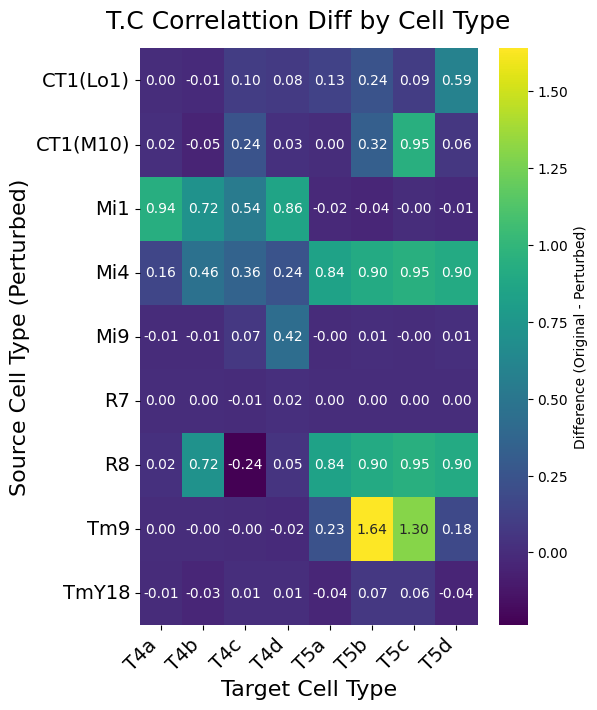

In [70]:
top_src_cell_types = ['CT1(Lo1)', 'CT1(M10)','Mi1', 'Mi4', 'Mi9', 'Tm9', 'R7', 'R8', 'TmY18']
filtered_plot_df = plot_df[plot_df.index.isin(top_src_cell_types)]
filtered_plot_df

plot_heat_map_small(filtered_plot_df)

### pair - wise analysis

In [6]:
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for pair_file in os.listdir(pair_wise_pert_path):
        pair = pair_file.replace(".csv", "")

        if pair not in results_map:
            results_map[pair] = {}

        df = pd.read_csv(f"{pair_wise_pert_path}/{pair_file}")
        df_ct_df = df[df.cell_type == cell_type]
        df_corr = df_ct_df[tc_corr_feature].values[0]
        diff_corr = origial_tc_corr - df_corr
        results_map[pair][cell_type] = diff_corr


diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)
plot_df = diff_results_df.set_index('src_cell_type')

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


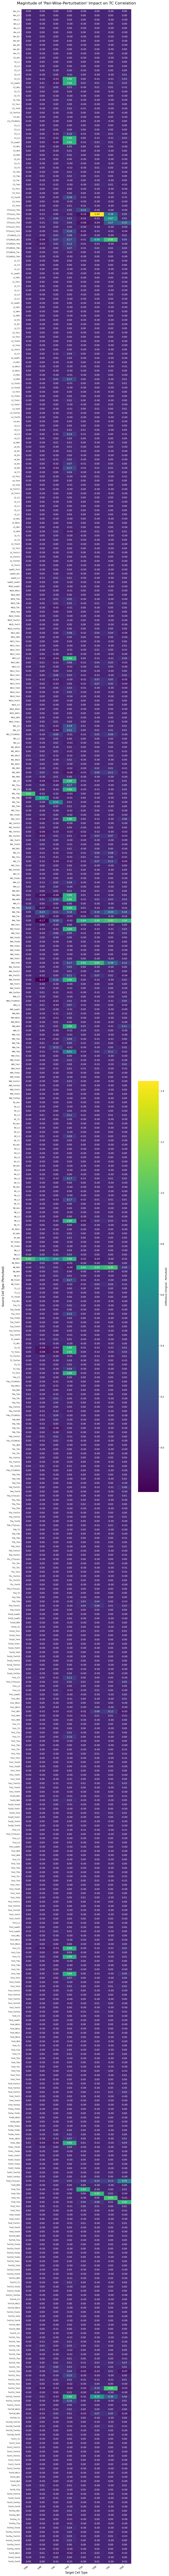

Top 10 Values: [1.44, 0.95, 0.95, 0.95, 0.95, 0.95, 0.937, 0.937, 0.903, 0.903]
Top 10 Names: ['CT1(Lo1)_T5b-T5b', 'CT1(M10)_Mi1-T5c', 'Mi4_T4d-T5c', 'R8_Mi4-T5c', 'Tm9_T5c-T5c', 'TmY15_Tm4-T5c', 'Mi1_T4a-T4a', 'R8_Mi1-T4a', 'Mi4_T4d-T5b', 'Mi4_Tm9-T5b']


In [7]:
plot_heat_map(plot_df, title_type='Pair-Wise')
print_top_10(plot_df)

### Motifs analysis

In [8]:
# Structure: { 'src_cell_type_name': {'T4a': val, 'T4b': val...} }
results_map = {}

for cell_type in origianl_network_res.cell_type:
    print(f"--- Processing Target: {cell_type} ---")
    ct_origianl = origianl_network_res[origianl_network_res.cell_type == cell_type]
    tc_corr_feature = get_tc_corr_feature(cell_type)
    origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

    for file in os.listdir(motif_pert_path):
        motif = file.replace(".csv", "")

        if motif not in results_map:
            results_map[motif] = {}

        # Load the pair-wise perturbation data
        try:
            df = pd.read_csv(f"{motif_pert_path}/{file}")
            df_ct_df = df[df.cell_type == cell_type]
            df_corr = df_ct_df[tc_corr_feature].values[0]
            diff_corr = (origial_tc_corr - df_corr)
            results_map[motif][cell_type] = diff_corr
        except FileNotFoundError:
            print(f"File not found for source: {src_cell_type}")
            results_map[src_cell_type][cell_type] = None

# 3. Convert the dictionary to the desired DataFrame
# orient='index' makes the dictionary keys (src_cell_type) the rows
diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')

# 4. Clean up: Move the index (src_cell_type) to a proper column
diff_results_df.index.name = 'src_cell_type'
diff_results_df.reset_index(inplace=True)

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


In [9]:
if 'src_cell_type' in diff_results_df.columns:
    plot_df = diff_results_df.set_index('src_cell_type')
else:
    # Assuming src_cell_type is already the index if the column doesn't exist
    plot_df = diff_results_df.copy()


In [10]:
origianl_network_res

,cell_type,pd_intensity1,pd_intensity0,dsi_intensity1,dsi_intensity0,dsi_correlation,tc_correlation_intensity1,tc_correlation_intensity0
0,T4a,3.080085,-0.133295,0.429780,0.079998,0.887835,0.937000,-0.534884
1,T4b,-0.161833,-2.677298,0.537967,0.010725,0.887835,0.719449,0.445971
2,T4c,0.981502,-2.334430,0.627362,0.092382,0.887835,0.537218,-0.164373
3,T4d,-1.506840,1.538510,0.098756,0.246006,0.887835,0.856611,-0.786793
4,T5a,0.351713,-3.042270,0.325475,0.778324,0.887835,-0.411445,0.841254
5,T5b,3.000525,-0.189463,0.172208,0.748803,0.887835,-0.308164,0.903209
6,T5c,-0.668891,1.822082,0.000583,0.579232,0.887835,-0.312159,0.949565
7,T5d,1.365778,-1.946797,0.034477,0.529629,0.887835,-0.442423,0.901005


In [11]:
df = pd.read_csv(f"{motif_pert_path}/{os.listdir(motif_pert_path)[0]}")
df

,cell_type,pd_intensity1,pd_intensity0,dsi_intensity1,dsi_intensity0,dsi_correlation,tc_correlation_intensity1,tc_correlation_intensity0
0,T4a,0.875055,-2.089942e+00,0.002478,5.598444e-17,-0.084285,0.166947,0.000000
1,T4b,-0.440303,-8.381903e-09,0.003385,4.385136e-09,-0.084285,0.126256,0.062440
2,T4c,0.054997,-2.553590e+00,0.002381,2.637605e-17,-0.084285,0.166194,0.000000
3,T4d,-2.725300,6.763233e-01,0.030699,2.363269e-03,-0.084285,0.364931,-0.184724
4,T5a,-2.434812,-2.908978e+00,0.006215,7.659481e-06,-0.084285,0.644502,0.878365
5,T5b,-0.343765,2.814641e+00,0.010806,4.905325e-06,-0.084285,0.733279,-0.306503
6,T5c,-0.249743,-2.619632e+00,0.003207,2.507753e-06,-0.084285,-0.481994,-0.010118
7,T5d,-1.649206,1.574100e+00,0.008742,1.547701e-06,-0.084285,0.843171,-0.593016


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


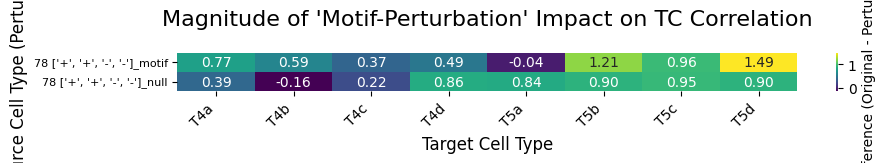

Top 10 Values: [1.494, 1.21, 0.96, 0.95, 0.903, 0.901, 0.857, 0.841, 0.77, 0.593]
Top 10 Names: ["78 ['+', '+', '-', '-']_motif-T5d", "78 ['+', '+', '-', '-']_motif-T5b", "78 ['+', '+', '-', '-']_motif-T5c", "78 ['+', '+', '-', '-']_null-T5c", "78 ['+', '+', '-', '-']_null-T5b", "78 ['+', '+', '-', '-']_null-T5d", "78 ['+', '+', '-', '-']_null-T4d", "78 ['+', '+', '-', '-']_null-T5a", "78 ['+', '+', '-', '-']_motif-T4a", "78 ['+', '+', '-', '-']_motif-T4b"]


In [12]:
plot_heat_map(plot_df, title_type='Motif')
print_top_10(plot_df)

### Motifs Feedback analysis

In [13]:
origianl_network_res_feedback.head()

,cell_type,dsi_correlation,pd_intensity0.0,dsi_intensity0.0,tc_correlation_intensity0.0,pd_intensity0.75,dsi_intensity0.75,tc_correlation_intensity0.75
0,T4a,0.886802,-0.133295,0.142799,-0.534884,3.071532,0.422398,0.934012
1,T4b,0.886802,-2.677298,0.020438,0.445971,-0.136448,0.558770,0.715704
2,T4c,0.886802,-2.334430,0.155467,-0.164373,1.036370,0.567511,0.576491
3,T4d,0.886802,1.538510,0.246006,-0.786793,-1.317781,0.032698,0.720889
4,T5a,0.886802,-3.042270,0.778324,0.841254,0.606658,0.189806,-0.205822


In [14]:
def feed_back_plot(dir_, intensity= 0.75):

    results_map = {}

    for cell_type in origianl_network_res_feedback.cell_type:
        print(f"--- Processing Target: {cell_type} ---")
        ct_origianl = origianl_network_res_feedback[origianl_network_res_feedback.cell_type == cell_type]
        tc_corr_feature = f'tc_correlation_intensity{intensity}'
        origial_tc_corr = ct_origianl[tc_corr_feature].values[0]

        for pattern in os.listdir(f'{feedback_path}/{dir_}'):
            pattern = str(pattern)
            df = pd.read_csv(f'{feedback_path}/{dir_}/{pattern}/res.csv')

            if pattern not in results_map:
                results_map[pattern] = {}

            df_ct_df = df[df.cell_type == cell_type]
            df_corr = df_ct_df[tc_corr_feature].values[0]
            diff_corr = (origial_tc_corr - df_corr) / (origial_tc_corr)
            results_map[pattern][cell_type] = diff_corr

    diff_results_df = pd.DataFrame.from_dict(results_map, orient='index')
    diff_results_df.index.name = 'src_cell_type'
    diff_results_df.reset_index(inplace=True)
    plot_df = diff_results_df.set_index('src_cell_type')

    plot_heat_map(plot_df, title_type=f'{dir_}')

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


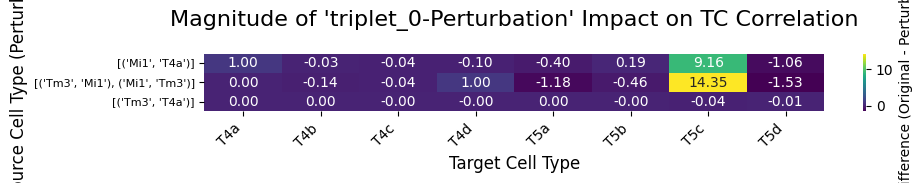

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


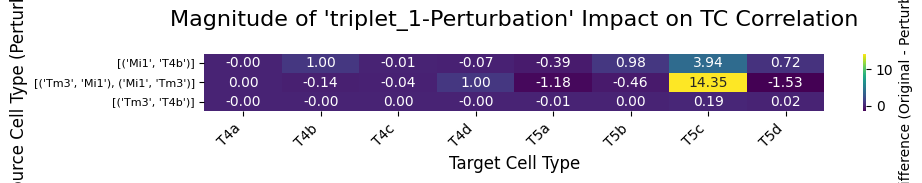

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


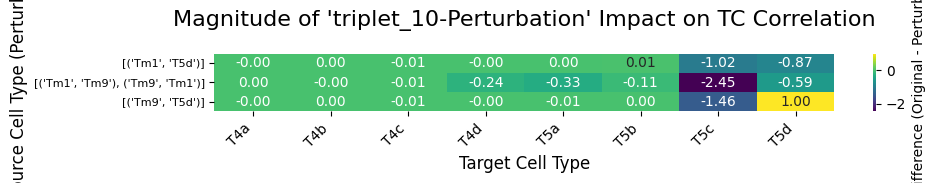

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


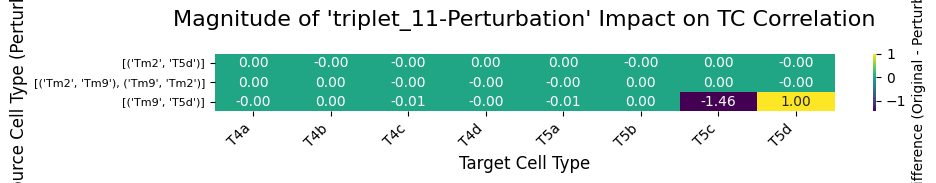

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


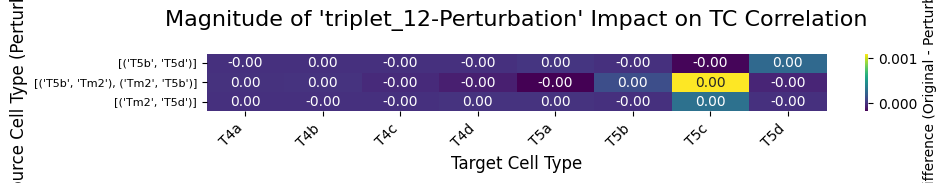

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


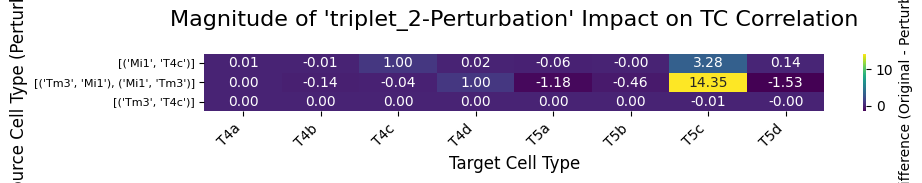

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


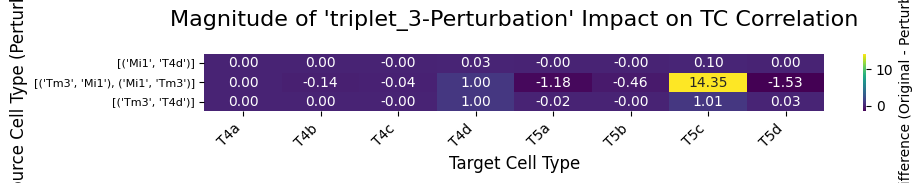

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


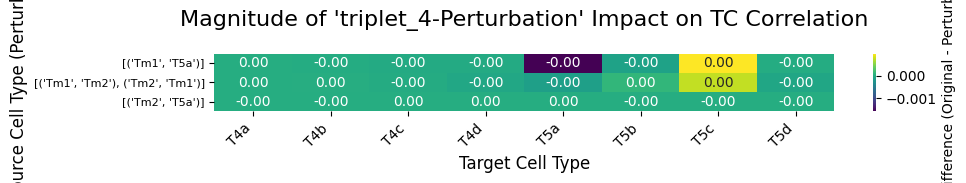

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


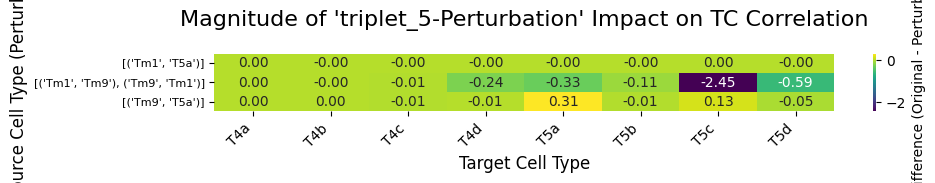

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


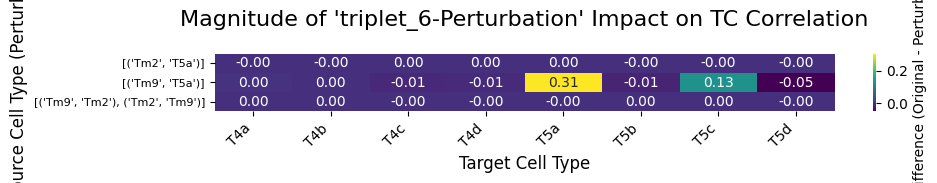

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


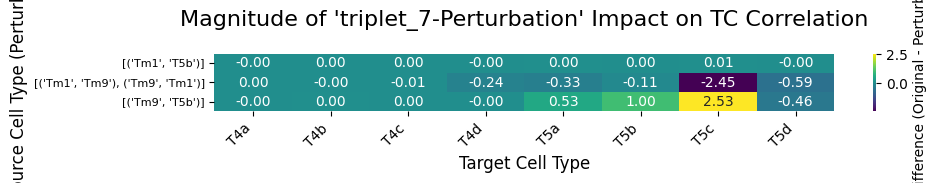

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


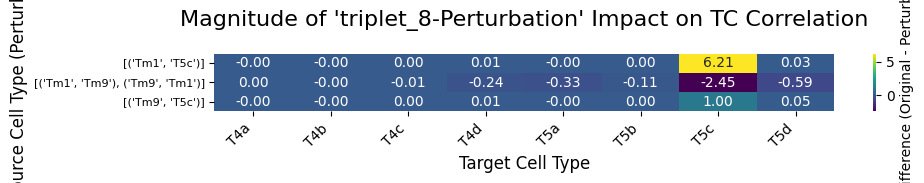

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


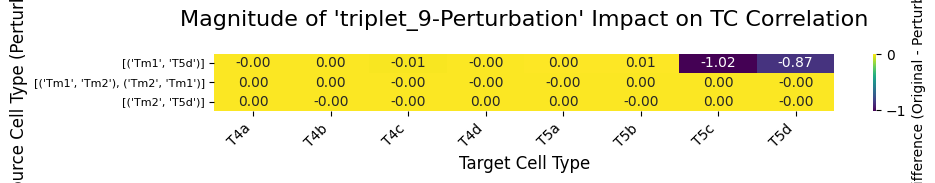

In [15]:
for dir_ in os.listdir(feedback_path):
    if dir_ == 'original':
        continue
    feed_back_plot(dir_)

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


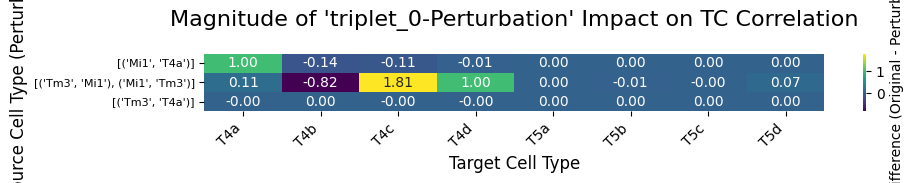

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


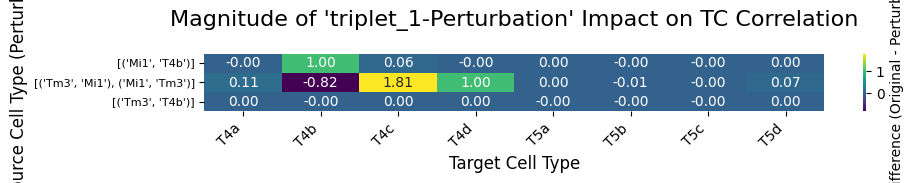

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


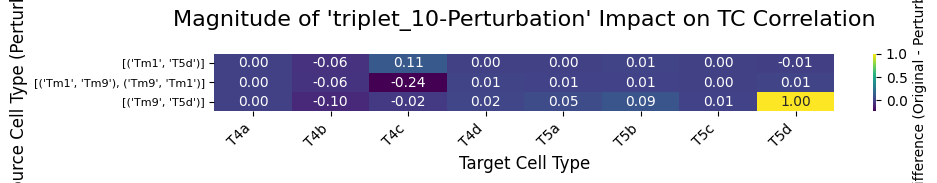

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


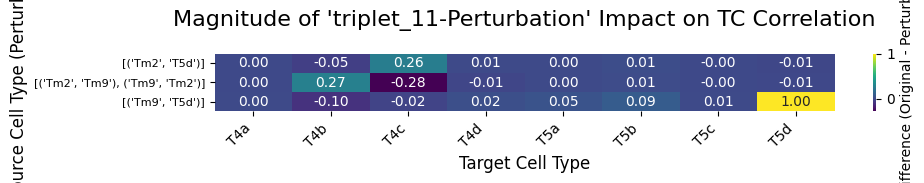

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


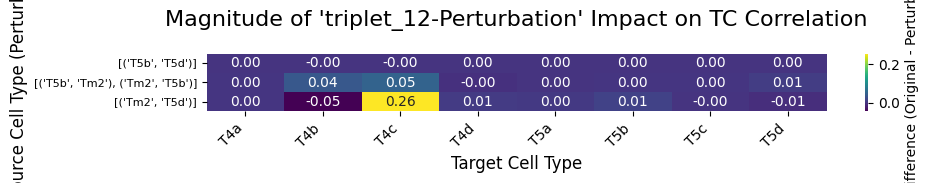

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


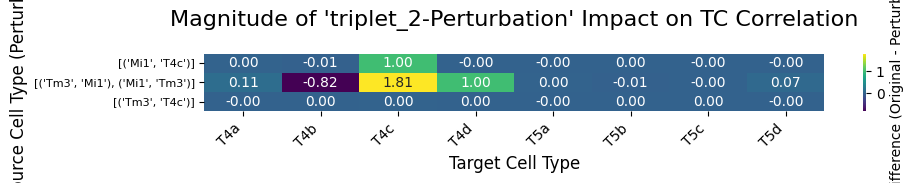

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


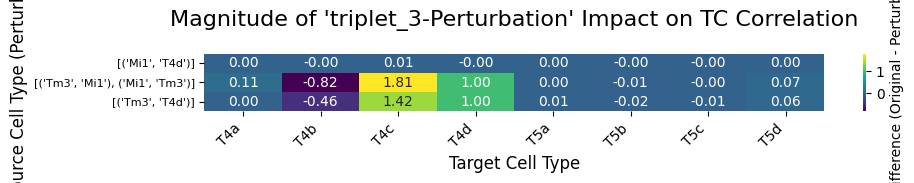

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


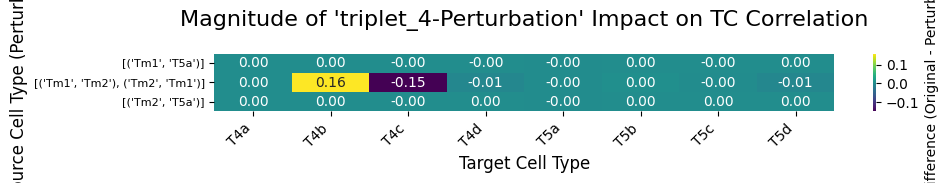

C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


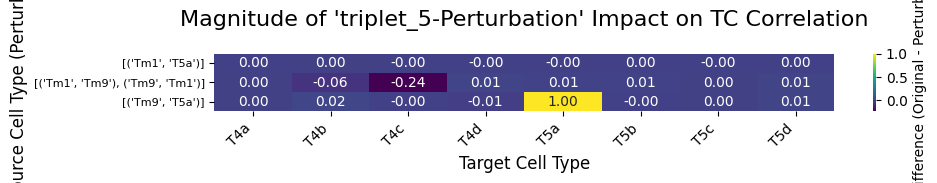

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


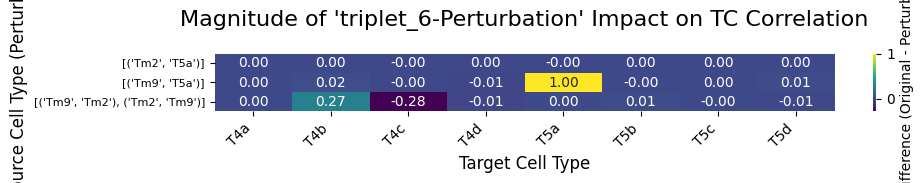

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


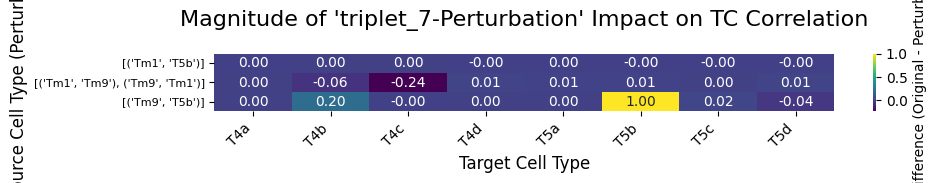

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


--- Processing Target: T5d ---


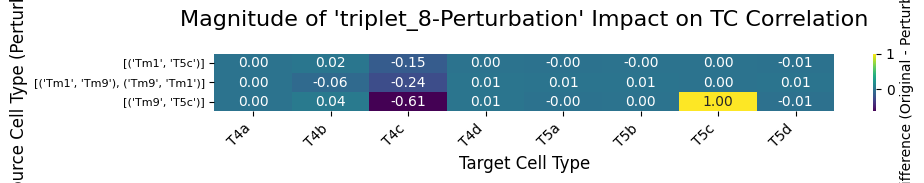

--- Processing Target: T4a ---
--- Processing Target: T4b ---
--- Processing Target: T4c ---
--- Processing Target: T4d ---
--- Processing Target: T5a ---
--- Processing Target: T5b ---
--- Processing Target: T5c ---
--- Processing Target: T5d ---


C:\Users\dean\AppData\Local\Temp\ipykernel_17188\1477978698.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


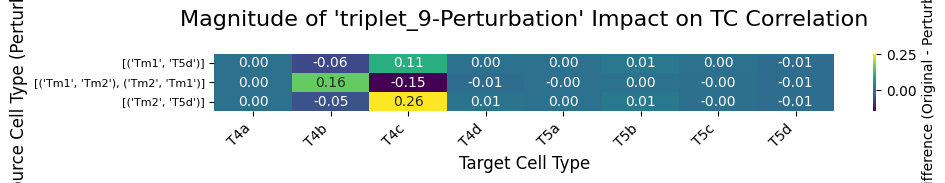

In [16]:
for dir_ in os.listdir(feedback_path):
    if dir_ == 'original':
        continue
    feed_back_plot(dir_, intensity=0.0)